<a href="https://colab.research.google.com/github/Tsxkii/AstroDataAnalysis/blob/main/GravitationalWaveCommented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install gwpy # Install the GWpy library for gravitational wave data analysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.9 MB/s eta 0:00:00
  Created wheel for ligo-segments: filename=ligo_segments-1.4.0-cp310-cp310-linux_x86_64.whl size=99227 sha256=9896b58ce36936c707df62c24c6849a6eda522cd02e4d8f9b1fde744017d8d2f
  Stored in directory: /root/.cache/pip/wheels/6d/48/d1/3466977be4e41ba57f92ad0d5619f083df43cf319a151c4e06
Successfully built ligo-segments


In [25]:
# # -- Set a GPS time:
#t0 = 1126259462.4    # -- GW150914
t0 = 1187008882.4    # -- GW170817 uncomment for this specific event

from gwpy.timeseries import TimeSeries # -- imports the necessary modules from gwpy for time series analysis
hdata = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)


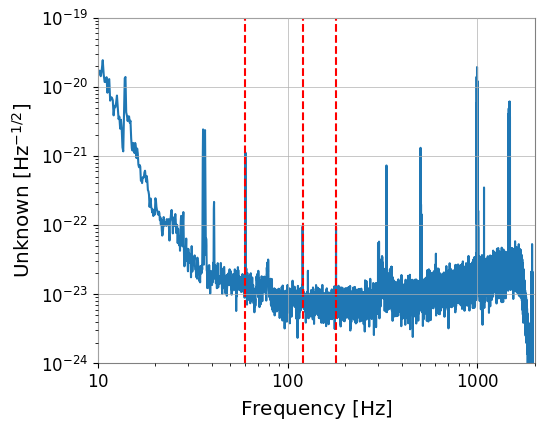

In [26]:
import matplotlib.pyplot as plt # Import the matplotlib library to plot data

# -- Plot ASD
fig2 = hdata.asd(fftlength=8).plot() #computes and plots the ASD with a FFT of 8 seconds
plt.xlim(10,2000)
ymin = 1e-24
ymax = 1e-19
plt.ylim(ymin, ymax)
plt.vlines(60, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(120, ymin, ymax, linestyle="dashed", color="red")
plt.vlines(180, ymin, ymax, linestyle="dashed", color="red")


In [27]:
from gwpy.signal import filter_design #filter design from gqpy
bp = filter_design.bandpass(50, 250, hdata.sample_rate) #bandpass filter to keep frequencies between 50 Hz and 250 Hz

notches = [filter_design.notch(line, hdata.sample_rate) for #notch filter to remove 60, 120, and 180 Hz
           line in (60, 120, 180)]

zpk = filter_design.concatenate_zpks(bp, *notches) #concatenate the bandpass and notch filters

hfilt = hdata.filter(zpk, filtfilt=True) #filter the data


In [28]:
hdata = hdata.crop(*hdata.span.contract(1)) #crop the data
hfilt = hfilt.crop(*hfilt.span.contract(1)) #crop the filtered data

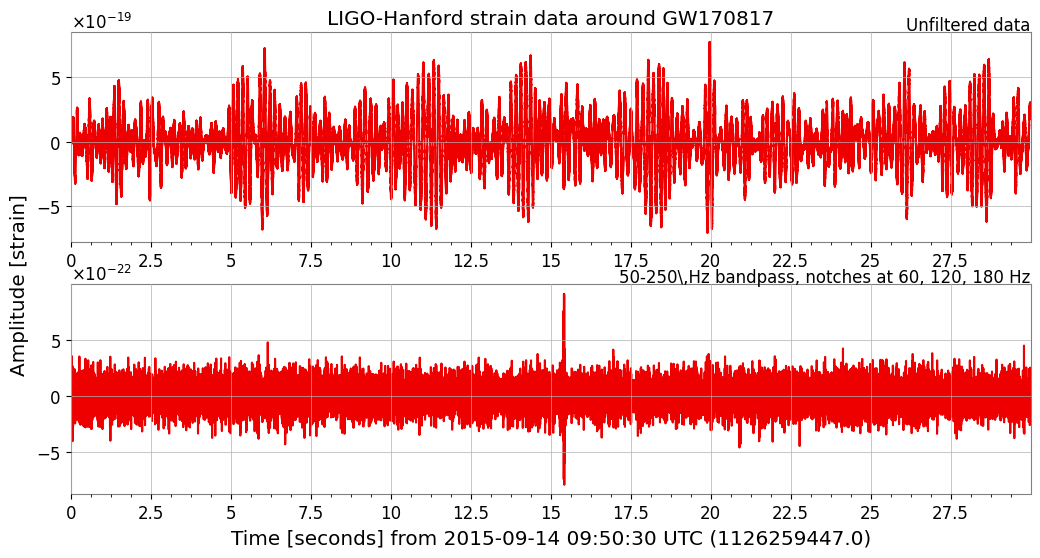

In [29]:
from gwpy.plot import Plot  # Import the Plot module from GWpy for visualization
#compare original data to filtered
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW170817')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()


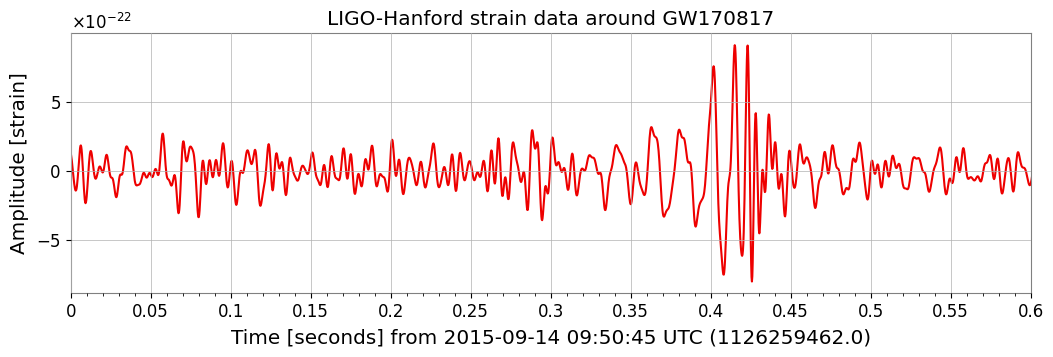

In [31]:
import matplotlib.pyplot as plt
# Plot the filtered data only
plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca() #the current axes for customization
ax.set_title('LIGO-Hanford strain data around GW170817')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)
plot.show()
# Retrieve x and y data from the previous plot for audio generation
x_val = plt.gca().lines[0].get_xdata() #xdata = time
y_val = plt.gca().lines[0].get_ydata() #ydata = strain

In [8]:
# Getopen data from the LIGO Livingston detector (L1) for the same time range
ldata = TimeSeries.fetch_open_data('L1', 1126259446, 1126259478) # Apply the same filter to the Livingston data
lfilt = ldata.filter(zpk, filtfilt=True) #filter the data



In [9]:
lfilt.shift('6.9ms') # Shift the data by 6.9ms
lfilt *= -1 # Invert the data

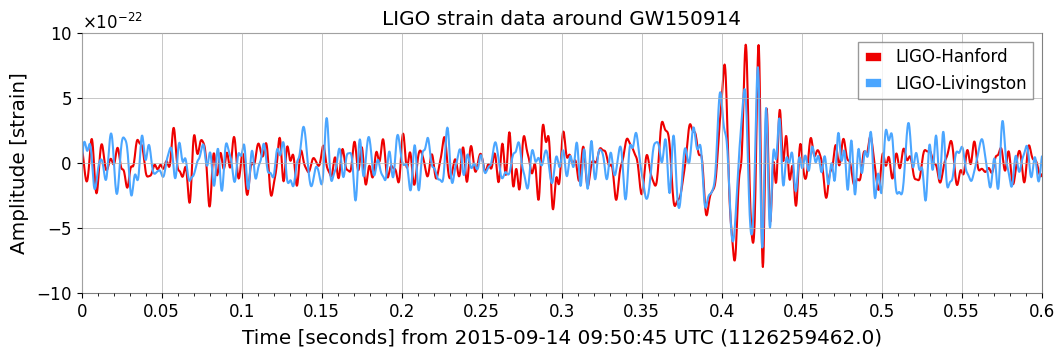

In [10]:
plot = Plot(figsize=[12, 4]) #plot to compare the filtered data from both detectors
ax = plot.gca()
ax.plot(hfilt, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(lfilt, label='LIGO-Livingston', color='gwpy:ligo-livingston')
ax.set_title('LIGO strain data around GW150914')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)
ax.set_ylabel('Amplitude [strain]')
ax.set_ylim(-1e-21, 1e-21)
ax.legend()
plot.show()


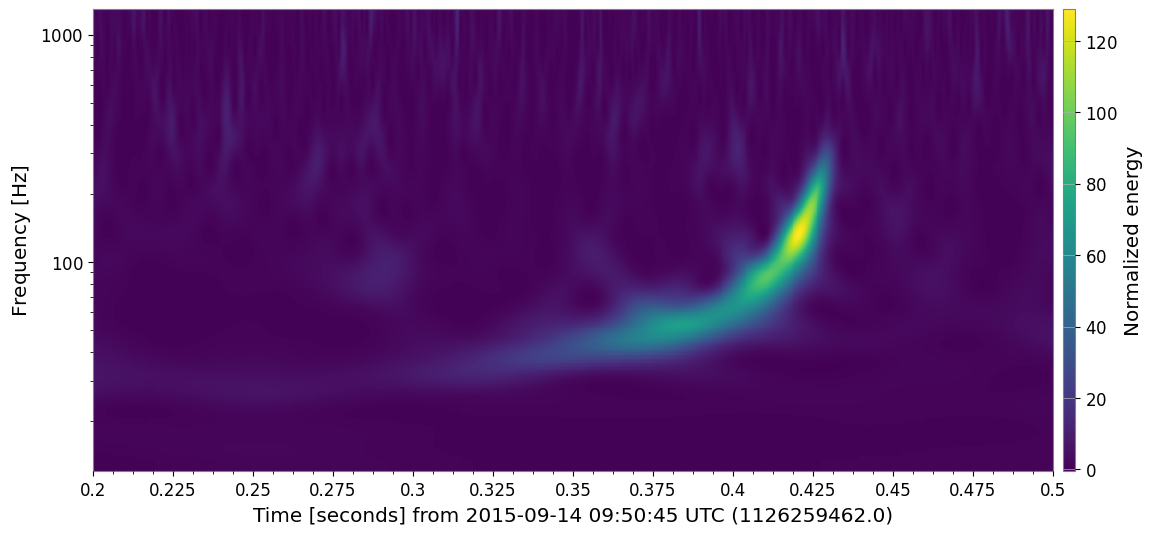

In [11]:
dt = 0.2  #-- Set width of q-transform plot, in seconds
hq = hfilt.q_transform(outseg=(t0-dt, t0+0.1)) # Compute the Q-transform for the filtered data to visualize time-frequency representation
fig4 = hq.plot()
ax = fig4.gca()
fig4.colorbar(label="Normalized energy")
ax.grid(False)
ax.set_yscale('log')


In [12]:
from scipy.io.wavfile import write #-- import the write function from scipy
import numpy as np #-- import numpy for numerical operations


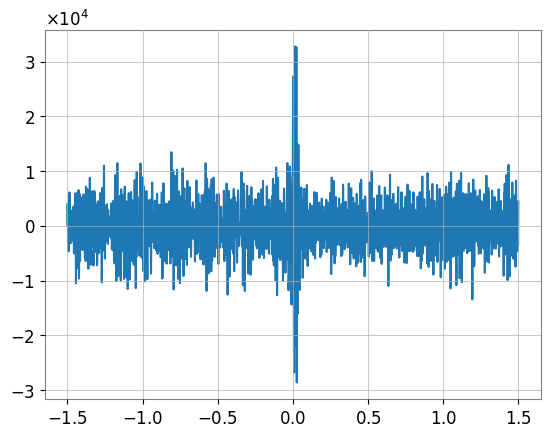

In [13]:
amplitude = np.iinfo(np.int16).max #maximum amplitude for 16-bit audio
# Select a segment of the data for audio conversion around the gravitational wave event
ind = np.where((x_val < (t0+1.5)) & (x_val > (t0-1.5)))
y = y_val[ind] #Extract the strain corresponding to the time range
# y = y**3
y = y / np.max(y)
plt.plot(x_val[ind] - t0, (np.array(y) * amplitude).astype(np.int16))


In [14]:
fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0)))) #-- Calculate the sampling frequency
print("fs = ", fs) #-- Print the sampling frequency
write("example.wav", fs, (np.array(y) * amplitude).astype(np.int16)) #-- Write the audio data to a WAV file

fs =  4096


In [15]:
from google.colab import files
files.download("example.wav")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

0.5
fs =  4096


<ipython-input-16-b61438791e13>:42: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(x - t0, (np.array(y_old) * amplitude).astype(np.int16), label="before frequency multiplication")
<ipython-input-16-b61438791e13>:49: ComplexWarning: Casting complex values to real discards the imaginary part
  plt.plot(x - t0, (np.array(y) * amplitude).astype(np.int16), label="after frequency multiplication")
<ipython-input-16-b61438791e13>:57: ComplexWarning: Casting complex values to real discards the imaginary part
  write("example.wav", fs, (np.array(y[0:int(num/up_sample)]) * amplitude).astype(np.int16))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

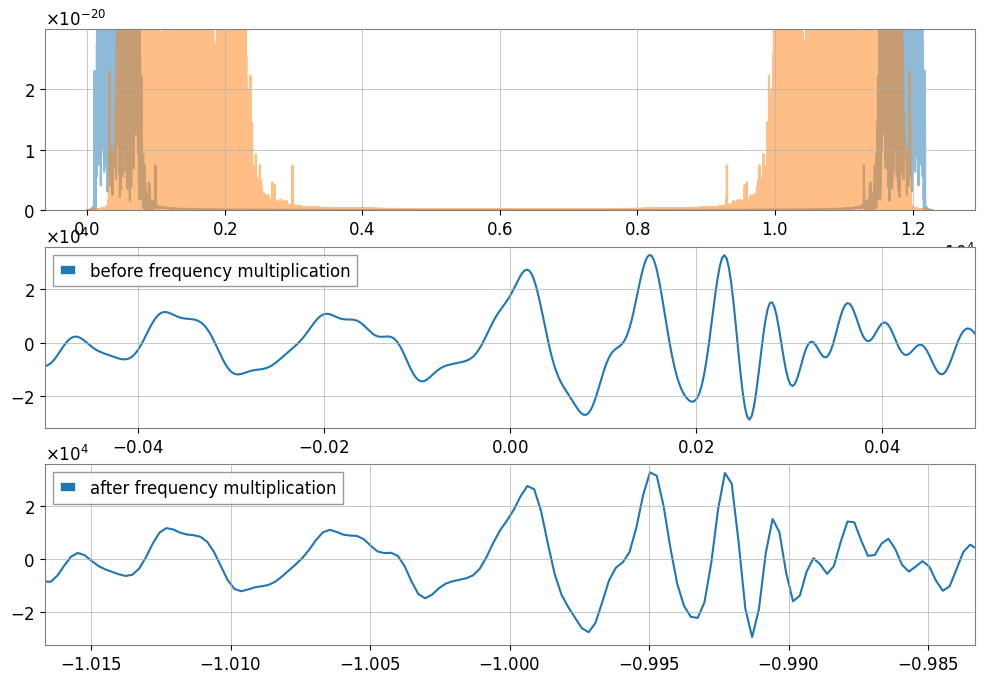

In [16]:
t_clip = 1.5 #-- Set the duration of the audio clip in seconds
amplitude = np.iinfo(np.int16).max #maximum amplitude for 16-bit audio

ind = np.where((x_val < (t0+t_clip)) & (x_val > (t0-t_clip))) #-- Select a segment of the data for audio conversion around the gravitational wave event
x = x_val[ind] #-- Extract the time values corresponding to the selected segment
y = y_val[ind] #-- Extract the strain corresponding to the time range

# plt.plot(x - t0, (np.array(y / np.max(y)) * amplitude) + 10000, label="oringinal")
# print(np.min(np.array(y / np.max(y)) * amplitude), np.max(np.array(y / np.max(y)) * amplitude))

up_sample = 3 #-- Set the up-sampling factor

y_fft = np.fft.fft(y) #-- Compute the FFT of the selected segment of data
# y_fft = np.fft.fftshift(y_fft)
y_fft_new = np.zeros(np.shape(y_fft), dtype=np.cdouble)
y_fft_old = y_fft

num = len(y_fft) #-- Get the number of samples in the FFT
for i in np.arange(int(num / up_sample)): #-- Apply the up-sampling factor to the FFT
    y_fft_new[int(i * up_sample)] = y_fft[int(i)]

y_old = np.fft.ifft(y_fft_old) #-- Compute the inverse FFT of the original data


for i in np.arange(num):
  if i > (num / 2):
    y_fft_new[i] = np.conjugate(y_fft_new[int(num) - i])

# y_fft_new = np.fft.fftshift(y_fft_new)
y = np.fft.ifft(y_fft_new)

plt.figure(figsize=(12,8))
plt.subplot(311)
plt.plot(np.abs(y_fft_old), alpha=0.5)
plt.plot(np.abs(y_fft_new), alpha=0.5)
ylim = np.percentile(np.abs(y_fft), 95)
plt.ylim(0, ylim)

plt.subplot(312)
# y_old = y_old**3 # to make the signal more distinct from the noise
y_old = y_old / np.max(y_old)
plt.plot(x - t0, (np.array(y_old) * amplitude).astype(np.int16), label="before frequency multiplication")
plt.xlim(-0.05, 0.05)
plt.legend()

plt.subplot(313)
# y = y**3 # to make the signal more distinct from the noise
y = y / np.max(y)
plt.plot(x - t0, (np.array(y) * amplitude).astype(np.int16), label="after frequency multiplication")
plt.xlim(-t_clip + t_clip / up_sample - 0.05 / up_sample, -t_clip + t_clip / up_sample + 0.05 / up_sample)
plt.legend()
print(t_clip / up_sample)

fs = int(1 / np.median(np.diff(np.array(x_val[ind] - t0))))
# fs = fs * 4 # to make the signal higher pitch
print("fs = ", fs)
write("example.wav", fs, (np.array(y[0:int(num/up_sample)]) * amplitude).astype(np.int16))

from google.colab import files
files.download("example.wav")


In [17]:
print(y_fft[0:4], y_fft[-3:])
print(y_fft_new[0:10], y_fft_new[-3:])
print(y_fft_old[0:4], y_fft_old[-3:])

[-6.07263394e-23+0.00000000e+00j -6.07384705e-23+2.84128011e-24j
 -6.07748733e-23+5.68319302e-24j -6.08355761e-23+8.52637255e-24j] [-6.08355761e-23-8.52637255e-24j -6.07748733e-23-5.68319302e-24j
 -6.07384705e-23-2.84128011e-24j]
[-6.07263394e-23+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j -6.07384705e-23+2.84128011e-24j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
 -6.07748733e-23+5.68319302e-24j  0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j -6.08355761e-23+8.52637255e-24j] [-6.07384705e-23-2.84128011e-24j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j]
[-6.07263394e-23+0.00000000e+00j -6.07384705e-23+2.84128011e-24j
 -6.07748733e-23+5.68319302e-24j -6.08355761e-23+8.52637255e-24j] [-6.08355761e-23-8.52637255e-24j -6.07748733e-23-5.68319302e-24j
 -6.07384705e-23-2.84128011e-24j]


In [18]:
!pip install pydub #-- Install the pydub library for audio processing
from pydub import AudioSegment #-- Import the AudioSegment class from pydub

In [19]:
sound = AudioSegment.from_file("example.wav") #-- Load the audio file
print(sound.frame_rate)
# sound.frame_rate = 1024
print(sound.frame_rate)
# sound.export("example_slow.wav")
# files.download("example_slow.wav")
sound = sound.set_frame_rate(4096 * 4)
sound.frame_rate = 4096 * 2
sound.export("example_slow.wav")
files.download("example_slow.wav")

4096
4096


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

(0.0, 0.1)

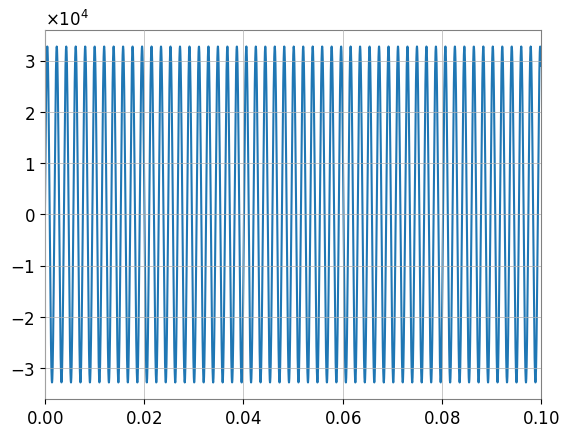

In [20]:
samplerate = 44100; fs = 261.63 * 2.0 #-- Set the sampling rate and frequency of the sine wave
t = np.linspace(0., 1., samplerate) #-- Create an array of time values
amplitude = np.iinfo(np.int16).max #-- Set the maximum amplitude for 16-bit audio
data = amplitude * np.sin(2. * np.pi * fs * t) #-- Generate the sine wave
plt.plot(t, data)
plt.xlim(0, 0.1)

In [21]:
write("C.wav", samplerate, data.astype(np.int16)) #-- Write the sine wave to a WAV file
files.download("C.wav")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:

c = 3.0e8  # speed of light in meters per second
solar_mass = 1.9885e30  # mass of the Sun in kilograms

# Masses of the merging black holes in solar masses
m1 = 36  # solar masses
m2 = 29  # solar masses
final_mass = 62  # solar masses after merger

# Convert masses to kilograms
m1_kg = m1 * solar_mass
m2_kg = m2 * solar_mass
final_mass_kg = final_mass * solar_mass

# Calculate mass loss and energy released
delta_m = (m1_kg + m2_kg) - final_mass_kg  # mass loss in kg
energy_released = delta_m * c**2  # energy in joules

# Convert energy to more convenient units (e.g., joules)
print(f"Mass loss: {delta_m:.2e} kg")
print(f"Energy released: {energy_released:.2e} joules")


Mass loss: 5.97e+30 kg
Energy released: 5.37e+47 joules
